In [37]:
"""
Super-resolution of CelebA using Generative Adversarial Networks.
The dataset can be downloaded from: https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADIKlz8PR9zr6Y20qbkunrba/Img/img_align_celeba.zip?dl=0
Instrustion on running the script:
1. Download the dataset from the provided link
2. Save the folder 'img_align_celeba' to 'datasets/'
4. Run the sript using command 'python srgan.py'
"""

from __future__ import print_function, division
import scipy

from keras.datasets import mnist
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
#from torch.utils.data import DataLoader
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os
from keras.preprocessing import image
from PIL import Image 
import random
import keras.backend as K

class SRGAN():
    def __init__(self):
        # Input shape
        self.channels = 3
        self.lr_height = 64                 # Low resolution height
        self.lr_width = 64                  # Low resolution width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = self.lr_height*4   # High resolution height
        self.hr_width = self.lr_width*4     # High resolution width
        self.hr_shape = (self.hr_height, self.hr_width, self.channels)

        # Number of residual blocks in the generator
        self.n_residual_blocks = 16

        optimizer = Adam(0.0002, 0.5)

        # We use a pre-trained VGG19 model to extract image features from the high resolution
        # and the generated high resolution images and minimize the mse between them
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Configure data loader
        self.dataset_name = 'celeb'
        self.img_res=(self.hr_height, self.hr_width)

        # Calculate output shape of D (PatchGAN)
        patch = int(self.hr_height / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # High res. and low res. images
        img_hr = Input(shape=self.hr_shape)
        img_lr = Input(shape=self.lr_shape)

        # Generate high res. version from low res.
        fake_hr = self.generator(img_lr)

        # Extract image features of the generated img
        fake_features = self.vgg(fake_hr)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminator determines validity of generated high res. images
        validity = self.discriminator(fake_hr)

        self.combined = Model([img_lr, img_hr], [validity, fake_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)


    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        vgg = VGG19(weights="imagenet")
        # Set outputs to outputs of last conv. layer in block 3
        # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        vgg.outputs = [vgg.layers[9].output]

        img = Input(shape=self.hr_shape)

        # Extract image features
        img_features = vgg(img)

        return Model(img, img_features)

    def build_generator(self):

        def residual_block(layer_input, filters):
            """Residual block described in paper"""
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        def deconv2d(layer_input):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(256, kernel_size=3, strides=1, padding='same')(u)
            u = Activation('relu')(u)
            return u

        # Low resolution image input
        img_lr = Input(shape=self.lr_shape)

        # Pre-residual block
        c1 = Conv2D(64, kernel_size=9, strides=1, padding='same')(img_lr)
        c1 = Activation('relu')(c1)

        # Propogate through residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        # Post-residual block
        c2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        u1 = deconv2d(c2)
        u2 = deconv2d(u1)

        # Generate high resolution output
        gen_hr = Conv2D(self.channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

        return Model(img_lr, gen_hr)

    def build_discriminator(self):

        def d_block(layer_input, filters, strides=1, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        # Input img
        d0 = Input(shape=self.hr_shape)

        d1 = d_block(d0, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)

        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(d0, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.load_data(batch_size)

            # From low res. image generate high res. version
            fake_hr = self.generator.predict(imgs_lr)

            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)

            # Train the discriminators (original images = real / generated = Fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_hr, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.load_data(batch_size)

            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(imgs_hr)

            # Train the generators
            g_loss = self.combined.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])

            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("%d time: %s" % (epoch, elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        #os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 2

        imgs_hr, imgs_lr = self.load_data(batch_size=2, is_testing=True)
        fake_hr = self.generator.predict(imgs_lr)

        # Rescale images 0 - 1
        imgs_lr = 0.5 * imgs_lr + 0.5
        fake_hr = 0.5 * fake_hr + 0.5
        imgs_hr = 0.5 * imgs_hr + 0.5 

        # Save generated images and the high resolution originals
        titles = ['Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for row in range(r):
            for col, image in enumerate([fake_hr, imgs_hr]):
                axs[row, col].imshow(image[row])
                axs[row, col].set_title(titles[col])
                axs[row, col].axis('off')
            cnt += 1
        fig.savefig("images/%d.png" % (epoch))
        plt.close()

        # Save low resolution images for comparison
        for i in range(r):
            fig = plt.figure()
            plt.imshow(imgs_lr[i])
            fig.savefig('images/%d_lowres%d.png' % (epoch, i))
            plt.close()
    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        DIR='D:\clebsa\img_align_celeba\img_align_celeba'
        a=[None for i in range(batch_size)]
        for i in range(batch_size):
            num=random.randint(0,202558)
            while(num in a):
                num=random.randint(0, 202558)
            a[i]=num
        imgs_hr = []
        imgs_lr = []
        a=list(a)
        for k in range(batch_size):
            a[k]=str(a[k])
            n=len(a[k])
            a[k]='0'*(6-n)+a[k]
            a[k]=a[k]+'.jpg'
        for img in a:
            img_path = os.path.join(DIR, img)            
            img = Image.open(img_path)

            h, w = self.img_res
            low_h, low_w = int(h / 4), int(w / 4)

            img_hr = img.resize(self.img_res, Image.ANTIALIAS)
            img_lr = img.resize((low_h, low_w), Image.ANTIALIAS)
            img_hr=np.asarray(img_hr)
            img_lr=np.asarray(img_lr)

            # If training => do random flip
            if not is_testing and np.random.random() < 0.5:
                img_hr = np.fliplr(img_hr)
                img_lr = np.fliplr(img_lr)

            imgs_hr.append(img_hr)
            imgs_lr.append(img_lr)

        imgs_hr = np.array(imgs_hr) / 127.5 - 1.
        imgs_lr = np.array(imgs_lr) / 127.5 - 1.

        return imgs_hr, imgs_lr

if __name__ == '__main__':
    gan = SRGAN()
    gan.train(epochs=1300, batch_size=1, sample_interval=5)

C:\Users\M.RINEETH\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 time: 0:00:48.447429


C:\Users\M.RINEETH\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 time: 0:01:10.374817
2 time: 0:01:25.484375
3 time: 0:01:40.782461
4 time: 0:01:55.699567
5 time: 0:02:10.671524
6 time: 0:02:33.153398
7 time: 0:02:48.081506
8 time: 0:03:03.030496
9 time: 0:03:17.987491
10 time: 0:03:33.058185
11 time: 0:03:55.372507
12 time: 0:04:11.007692
13 time: 0:04:26.486295
14 time: 0:04:41.557016
15 time: 0:04:56.623695
16 time: 0:05:19.147456
17 time: 0:05:34.968145
18 time: 0:05:50.194453
19 time: 0:06:05.337953
20 time: 0:06:20.587137
21 time: 0:06:43.779111
22 time: 0:06:59.052266
23 time: 0:07:14.359327
24 time: 0:07:29.675366
25 time: 0:07:45.136016
26 time: 0:08:08.861562
27 time: 0:08:24.969483
28 time: 0:08:41.366631
29 time: 0:08:58.419024
30 time: 0:09:14.382331
31 time: 0:09:37.493522
32 time: 0:09:52.727778
33 time: 0:10:08.033875
34 time: 0:10:23.256132
35 time: 0:10:38.859401
36 time: 0:11:01.781130
37 time: 0:11:17.593841
38 time: 0:11:33.860304
39 time: 0:11:49.612176
40 time: 0:12:04.791580
41 time: 0:12:27.304371
42 time: 0:12:42.446871
4

In [45]:
DIR='D:\clebsa\img_align_celeba\img_align_celeba'
img='000167.jpg'
imgs_hr=[]
imgs_lr=[]
img_path = os.path.join(DIR, img)            
img = Image.open(img_path)

h, w = gan.img_res
low_h, low_w = int(h / 4), int(w / 4)

img_hr = img.resize(gan.img_res, Image.ANTIALIAS)
img_lr = img.resize((low_h, low_w), Image.ANTIALIAS)
img_hr=np.asarray(img_hr)
img_lr=np.asarray(img_lr)
            
            


imgs_hr.append(img_hr)
imgs_lr.append(img_lr)

imgs_hr = np.array(imgs_hr)/127.5-1
imgs_lr = np.array(imgs_lr)/127.5-1

fake_hr=gan.generator.predict(imgs_lr)
fake_hr = 0.5 * fake_hr + 0.5

fig = plt.figure()
plt.imshow(fake_hr[0])
fig.savefig('images/%dtest.png' % (1))
plt.close()

In [48]:
gan.generator.save('D:\clebsa\model\srgan_generator_celebsa.h5')

In [51]:
from keras.models import load_model
new_model=load_model('D:\clebsa\model\srgan_generator_celebsa.h5')

In [53]:
gan.discriminator.save('D:\clebsa\model\srgan_discriminator_celebsa.h5')
gan.combined.save('D:\clebsa\model\srgan_combined_celebsa.h5')

In [55]:
gan.vgg.save('D:\clebsa\model\srgan_vgg_celebsa.h5')

IndexError: too many indices for array

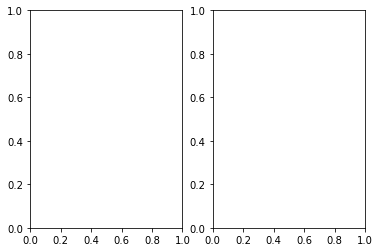

In [20]:
from tensorflow.keras.models import load_model
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
new_model=load_model('D:\clebsa\model\srgan_generator_celebsa.h5')
DIR='D:\clebsa'
img='index.jpg'
imgs_hr=[]
imgs_lr=[]
img_path = os.path.join(DIR,img)            
img = Image.open(img_path)

h, w = 64*4,64*4
low_h, low_w = int(h / 4), int(w / 4)

img_hr = img.resize((h,w), Image.ANTIALIAS)
img_lr = img.resize((low_h, low_w), Image.ANTIALIAS)
img_hr=np.asarray(img_hr)
img_lr=np.asarray(img_lr)
            
            


imgs_hr.append(img_hr)
imgs_lr.append(img_lr)

imgs_hr = np.array(imgs_hr)/127.5-1
imgs_lr = np.array(imgs_lr)/127.5-1

fake_hr=new_model.predict(imgs_lr)
fake_hr = 0.5 * fake_hr + 0.5

fig = plt.figure()
plt.imshow(fake_hr[0])
fig.savefig('D:\\clebsa\\tay.png')
plt.close()

print('over')